In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.regularizers import l2
import datetime

In [2]:
!mkdir kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d ma7555/cat-breeds-dataset

100% 1.92G/1.93G [00:45<00:00, 61.6MB/s]
100% 1.93G/1.93G [00:45<00:00, 45.8MB/s]


In [7]:
! mkdir cat_breed_data

In [12]:
! unzip cat-breeds-dataset.zip -d cat_breed_data 

Streaming output truncated to the last 5000 lines.
  inflating: cat_breed_data/images/Tortoiseshell/46495717_25061.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46495784_25049.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46495794_25052.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46496797_24946.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46497000_24936.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46497664_24825.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46500078_24567.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46504471_24003.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46507777_23590.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46510043_23381.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46510643_23331.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46512081_23194.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46513326_23056.jpg  
  inflating: cat_breed_data/images/Tort

In [14]:
! mkdir data
! mkdir data/Train
! mkdir data/Test

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/Train’: File exists
mkdir: cannot create directory ‘data/Test’: File exists


In [13]:
cat_breed = ['Bombay', 'Calico', 'Burmese', 'Himalayan', 'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 'Dilute Calico']
path = "/content/data/Train/"
for i in cat_breed:
  os.mkdir(path+i)
path2 = "/content/data/Test/"
for i in cat_breed:
  os.mkdir(path2+i)

FileExistsError: ignored

In [15]:
import shutil
import os
cat_breed = ['Bombay', 'Calico', 'Burmese', 'Himalayan', 'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 'Dilute Calico']
for folder_name in cat_breed:
  source_dir = '/content/cat_breed_data/images/' + folder_name 
  target_dir_train = '/content/data/Train/' + folder_name
  target_dir_test = '/content/data/Test/' + folder_name

  file_names = os.listdir(source_dir)

  for file_name in file_names:
    if np.random.rand(1) < 0.2:
      shutil.copy(os.path.join(source_dir, file_name), target_dir_test)
    else:
      shutil.copy(os.path.join(source_dir, file_name), target_dir_train)

In [16]:
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=15, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2,
                                     shear_range=0.2, 
                                     zoom_range=0.2,
                                     ) # inception preprocessing

test_generator = ImageDataGenerator(rescale=1./255) # inception preprocessing


In [17]:
train_data_dir = "/content/data/Train"
test_data_dir = "/content/data/Test"

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(300,300),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64, 
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(300, 300),
                                             class_mode='categorical',
                                             batch_size=64,
                                             shuffle=False,
                                             seed=42)

Found 12495 images belonging to 10 classes.
Found 3159 images belonging to 10 classes.


In [21]:
def create_model(input_shape, n_classes, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = InceptionV3(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output

    conv_layer_1 = Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(top_model)
    Pool_1 = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(conv_layer_1)
    batch_norm_1 = BatchNormalization()(Pool_1)

    conv_layer_2 = Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(batch_norm_1)
    Pool_2 = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(conv_layer_2)
    batch_norm_2 = BatchNormalization()(Pool_2)

    flatten = Flatten()(batch_norm_2)

    FC_1 = Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(flatten)
    batch_norm_4 = BatchNormalization()(FC_1)

    FC_2 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=l2(0.001))(batch_norm_4)

    dropout = Dropout(0.5)(FC_2)
    output_layer = Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(dropout)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optim_1, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy','AUC'])
    model.summary()
    
    return model

In [19]:
!pip install git+git://github.com/stared/livelossplot.git --upgrade --quiet

In [25]:
tf.keras.backend.clear_session()
input_shape = (299, 299, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // 128
#n_val_steps = validgen.samples // 128
n_epochs = 100

incp_model = create_model(input_shape, n_classes, fine_tune=0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10, min_delta=0.005,
                           restore_best_weights=True,
                           mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2)

terminate = TerminateOnNaN()

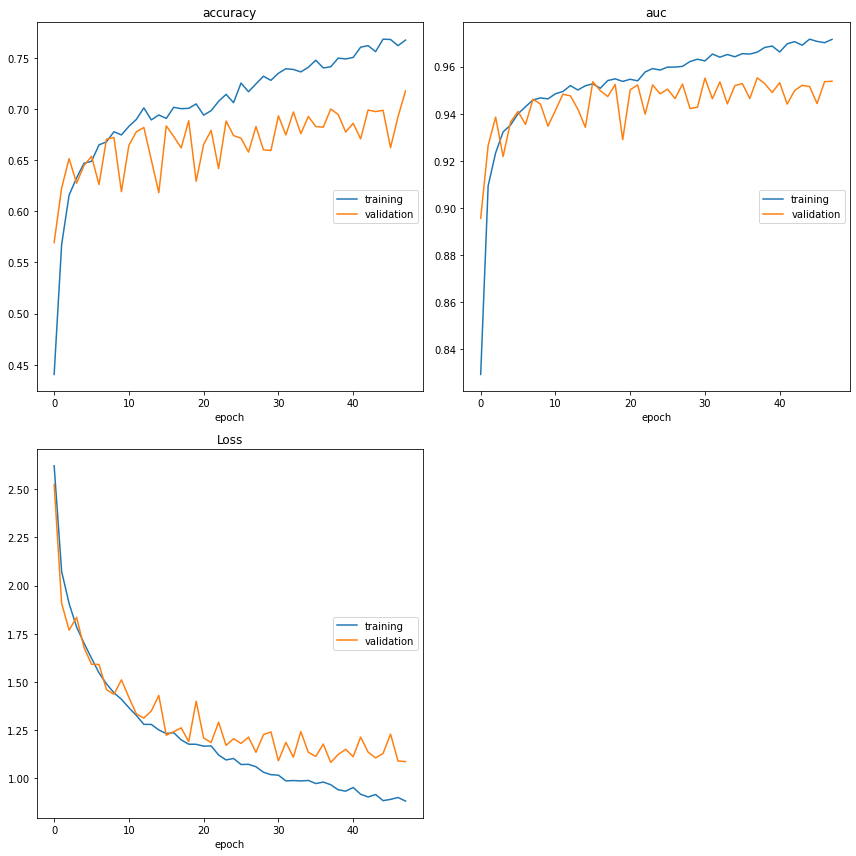

accuracy
	training         	 (min:    0.441, max:    0.768, cur:    0.767)
	validation       	 (min:    0.569, max:    0.718, cur:    0.718)
auc
	training         	 (min:    0.829, max:    0.972, cur:    0.972)
	validation       	 (min:    0.896, max:    0.955, cur:    0.954)
Loss
	training         	 (min:    0.881, max:    2.622, cur:    0.881)
	validation       	 (min:    1.082, max:    2.526, cur:    1.086)
CPU times: user 2h 29min 5s, sys: 3min 48s, total: 2h 32min 53s
Wall time: 2h 32min 16s


In [27]:
%%time
incp_history = incp_model.fit(traingen,
                            epochs=n_epochs,
                            validation_data=testgen,
                            steps_per_epoch=n_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1, reduce_lr, terminate],
                            verbose=1)